## Часть 1
Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты. 

In [5]:
import telethon
import json
import pandas as pd
from datetime import datetime


In [71]:
chat = "Sputnik_results"
await client.start()
file = open("data.json", mode='w', encoding='utf8')
dicts = []

In [72]:
async for messages in client.iter_messages(chat):
    dicts.append({"id": messages.id, "text": messages.text, "date": messages.date})

json.dump(dicts, file, ensure_ascii=False, indent=6, default=str)


file.close()


In [7]:
with open("data.json", encoding='utf8') as file:
    templates = json.load(file)



In [8]:

df = pd.DataFrame(templates, columns = ['id', 'text', 'date'])
df2 = pd.DataFrame(pd.to_datetime(df['date']).dt.date)
plot_data = df2.groupby(by='date', axis=0, as_index=False).size()
print(plot_data)

           date  size
0    2020-12-08     1
1    2020-12-09   214
2    2020-12-10   107
3    2020-12-11    17
4    2020-12-12     5
..          ...   ...
371  2021-12-14    14
372  2021-12-15    15
373  2021-12-16    20
374  2021-12-17    16
375  2021-12-18    15

[376 rows x 2 columns]


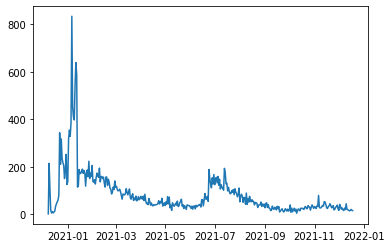

In [9]:
import matplotlib.pyplot as plt

plt.plot(plot_data['date'], plot_data['size'])

### Часть 2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательная визуализация. 

In [10]:
import re

def test(df):
    result = []
    for message in df['text']:
        if type(message) is str and len(message) > 0:
            if message[0] == 'Ж' or message[0] == 'М':
                tmp = re.findall(r'[^]{0,1}[\n]{0,1}[МЖмж][.,\s(]{0,3}[1-9]{1}[0-9]{1}', message)
                for element in tmp:
                    if element[0] in ('Ж', 'М', 'м', 'ж') and int(element[-2:]) >= 18:
                        if element[0] in ('Ж', 'ж'):
                            result.append(['Ж', int(element[-2:])])
                        else:
                            result.append(['М', int(element[-2:])])
    return result


In [11]:
dict = test(df)
df_sex_age = pd.DataFrame(dict, columns=('sex', 'age'))
# print(df_sex_age)
df_sex = df_sex_age.groupby(by='sex', axis=0, as_index=False).size()
# print(df_sex)
df_age = df_sex_age.groupby(by='age', axis=0, as_index=False).size()
# print(df_age)

(-1.112680501413499,
 1.1006038741672683,
 -1.119632060032795,
 1.1140386644486642)

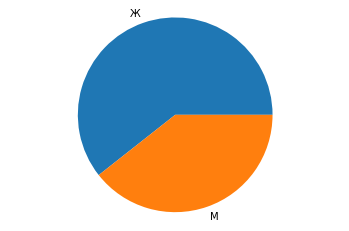

In [12]:
fig, ax = plt.subplots()
ax.pie(df_sex['size'], labels=df_sex['sex'])
ax.axis("equal")


<BarContainer object of 77 artists>

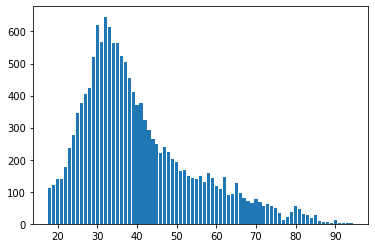

In [18]:
plt.bar(df_age['age'], df_age['size'])

In [43]:
def temperature(message):
        sum = 0
        if type(message) is str and len(message) > 0:
            tmp = re.findall(r'3\d[.,]\d', message)
            if len(tmp) > 0:
                for element in tmp:
                    if element[2] == ',':
                        element = ('.').join(element.split(','))
                    sum += float(element)
                mean_t = sum / len(tmp)
                return mean_t
            else:
                return 0

def age(message):
    if type(message) is str and len(message) > 0:
        if message[0] == 'Ж' or message[0] == 'М':
            tmp = re.findall(r'[^]{0,1}[\n]{0,1}[МЖмж][.,\s(]{0,3}[1-9]{1}[0-9]{1}', message)
            for element in tmp:
                if element[0] in ('Ж', 'М', 'м', 'ж') and int(element[-2:]) >= 18:
                    return int(element[-2:])
                else:
                    return 0
        else:
            return 0
    else:
        return 0


In [42]:
df['temperature'] = df.text.apply(lambda x: temperature(x))

,id,text,date,temperature
0,136711,"Это было плацебо, как выяснилось.\nУже сделали...",2021-12-18 16:00:01+00:00,36.9
1,136710,М 34\n24.11.21 V1 Sputnik V: Общее недомогание...,2021-12-18 15:11:42+00:00,0.0
2,136709,**Народные отчеты о вакцинации\n\n**⚠️ **ТОЛЬК...,2021-12-18 15:00:02+00:00,0.0
3,136707,Ж 51 \nПароксизмальная наджелудочковая тахикар...,2021-12-18 14:08:04+00:00,0.0
4,136681,,2021-12-18 13:43:39+00:00,NaN
...,...,...,...,...
30729,5,None,2020-12-09 15:45:57+00:00,NaN
30730,4,None,2020-12-09 15:45:53+00:00,NaN
30731,3,None,2020-12-09 15:45:45+00:00,NaN
30732,2,None,2020-12-09 11:17:38+00:00,NaN


## Повышение температуры у людей 30+

<AxesSubplot:xlabel='age', ylabel='temperature'>

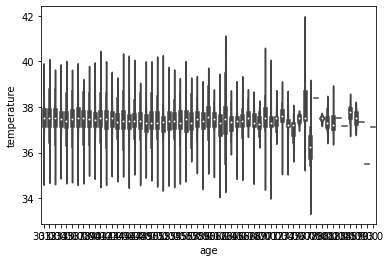

In [46]:
import seaborn as sns
df['age'] = df.text.apply(lambda x: age(x))
df = df.explode('age')
df_choose = df[(df.temperature >= 35) & (df.age >= 30)][['temperature', 'age']]
sns.violinplot(x='age', y='temperature', data = df_choose)